In [1]:
import json

from manim import *
import pandas as pd

from loldle_solver.solver import Solver, calc_entropy

Manim Community v0.18.0

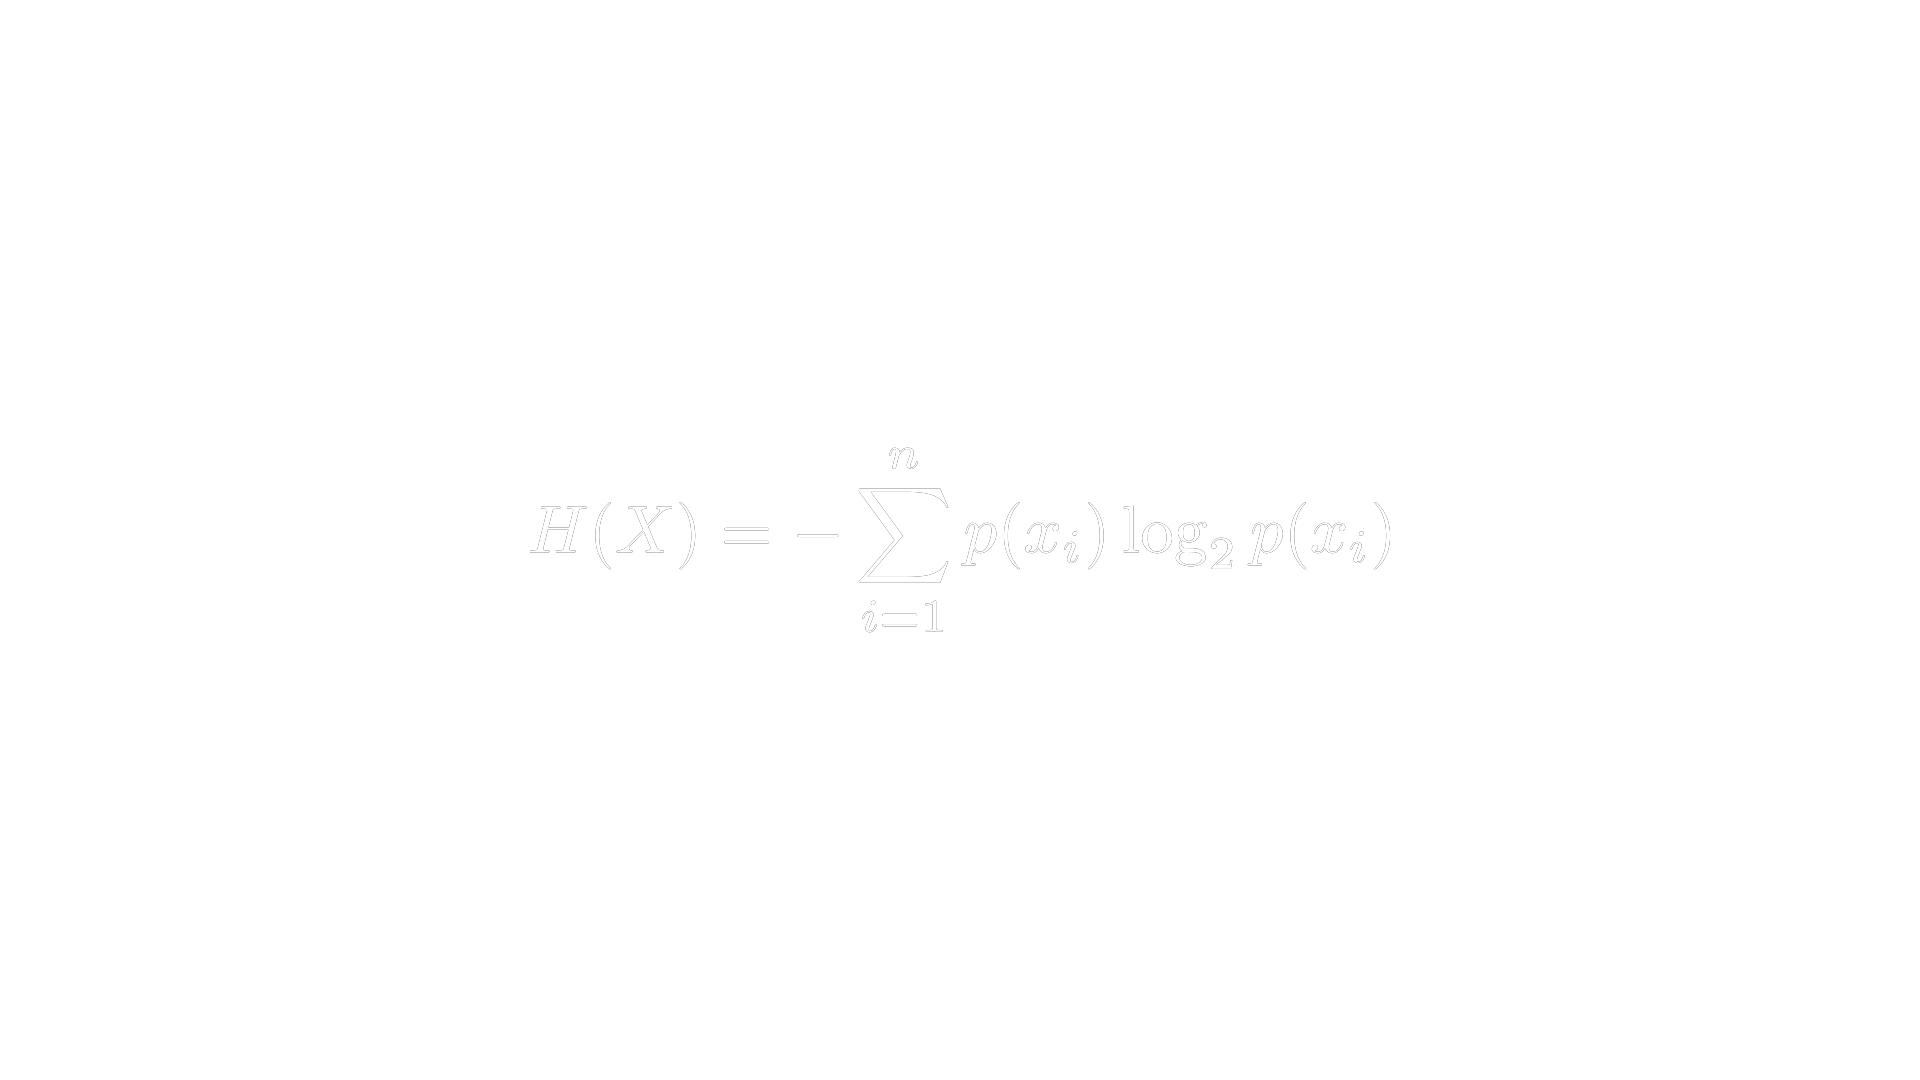

In [21]:
%%manim -qh -s -t --format png -v WARNING EntropyFormula

class EntropyFormula(Scene):
    def construct(self):
        entropy_formula = MathTex(r"H(X) = -\sum_{i=1}^{n} p(x_i) \log_2 p(x_i)")
        self.add(entropy_formula)


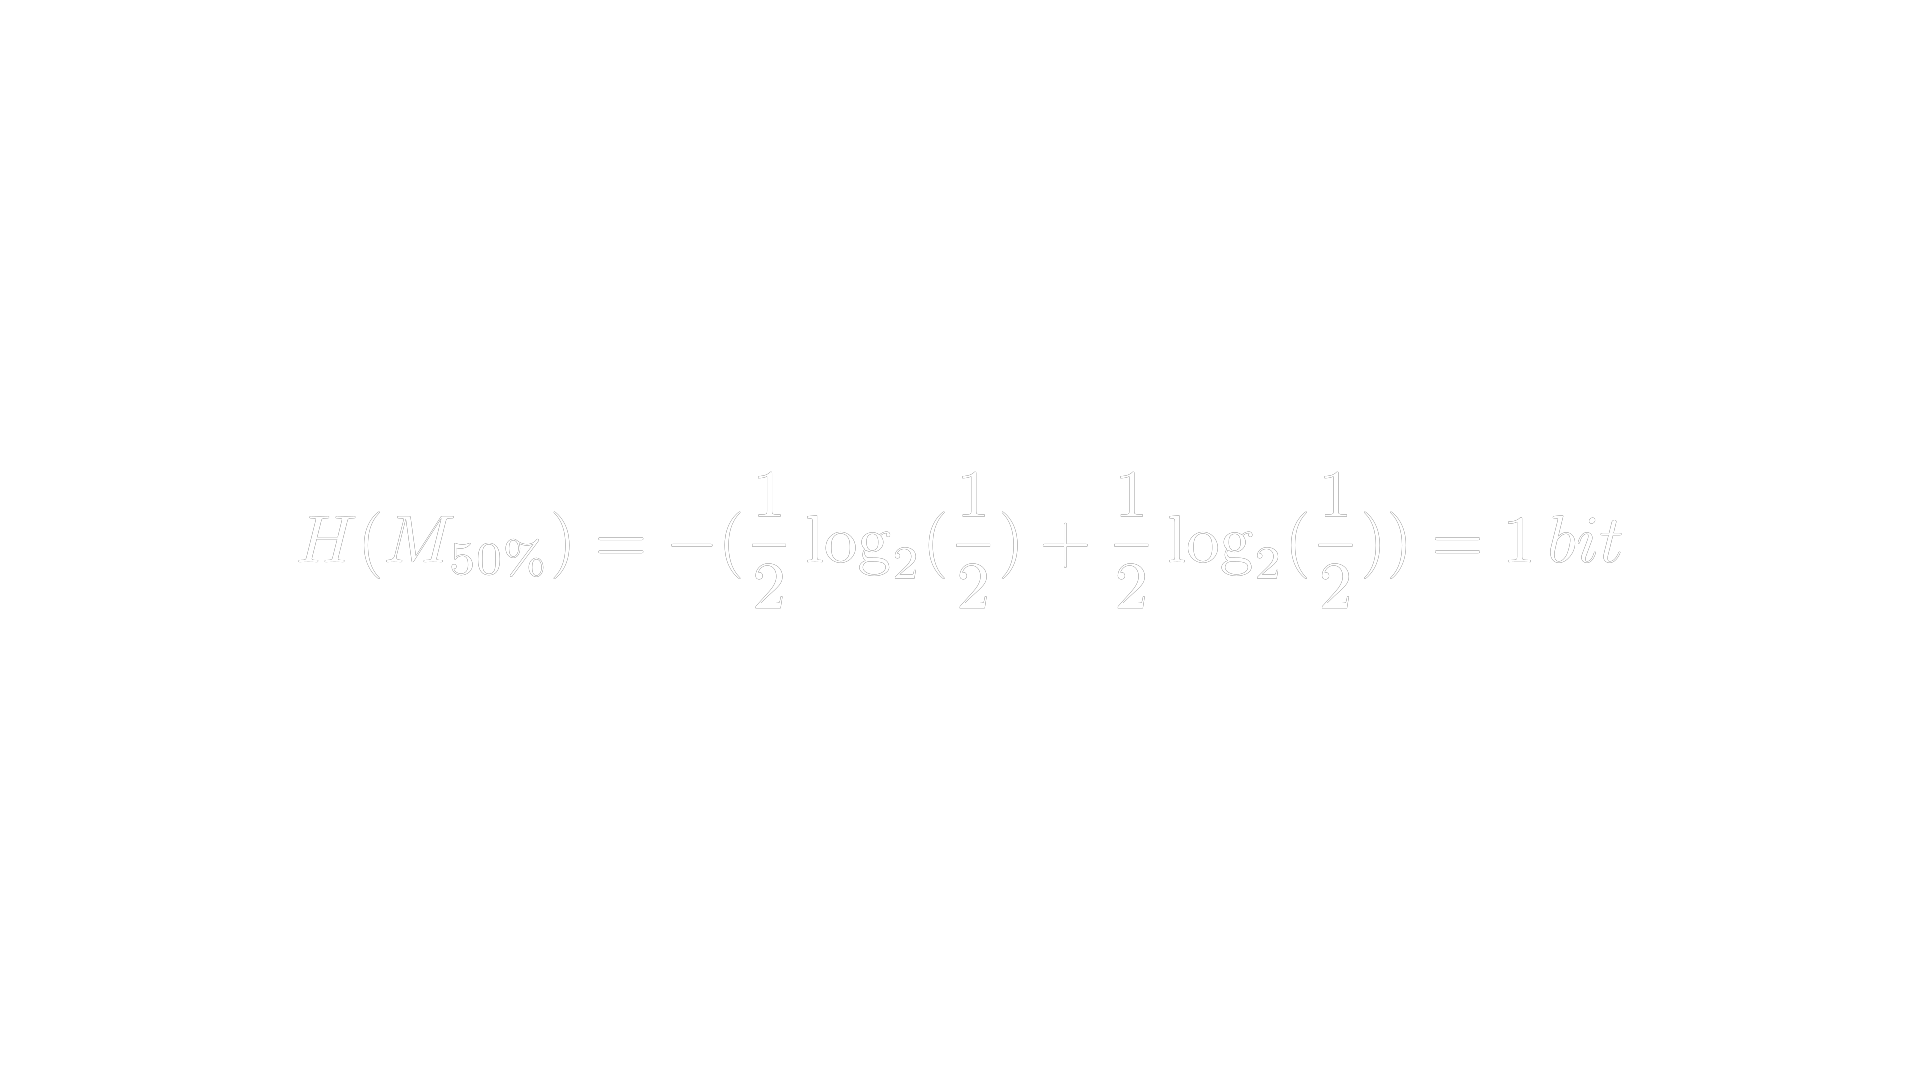

In [42]:
%%manim -qh -s -t --format png -v WARNING EntropyCoin

class EntropyCoin(Scene):
    def construct(self):
        entropy_formula = MathTex(r"H(M_{50\%}) = - (\frac{1}{2} \log_2 (\frac{1}{2}) + \frac{1}{2} \log_2 (\frac{1}{2})) = 1\,bit")
        self.add(entropy_formula)


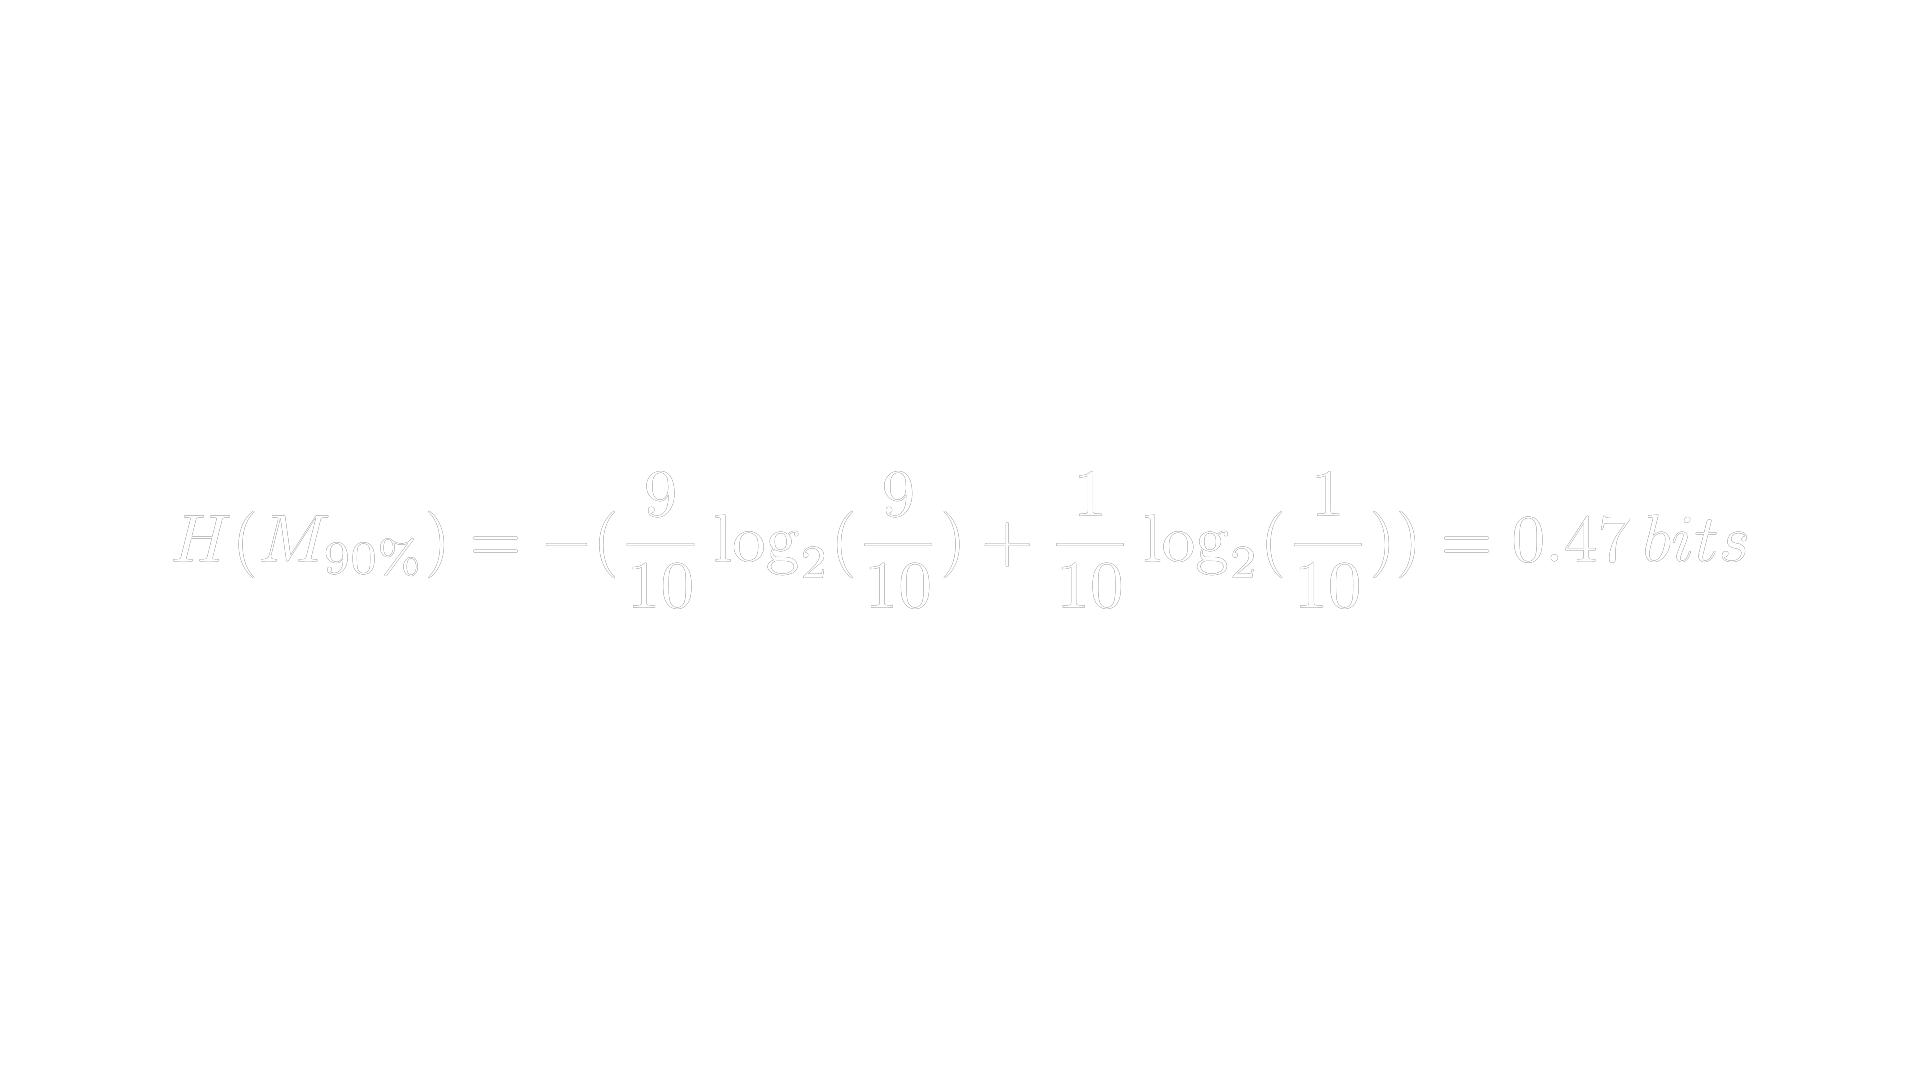

In [47]:
%%manim -qh -s -t --format png -v WARNING EntropyRigged

class EntropyRigged(Scene):
    def construct(self):
        entropy_formula = MathTex(r"H(M_{90\%}) = - (\frac{9}{10} \log_2 (\frac{9}{10}) + \frac{1}{10} \log_2 (\frac{1}{10})) = 0.47\,bits")
        self.add(entropy_formula)


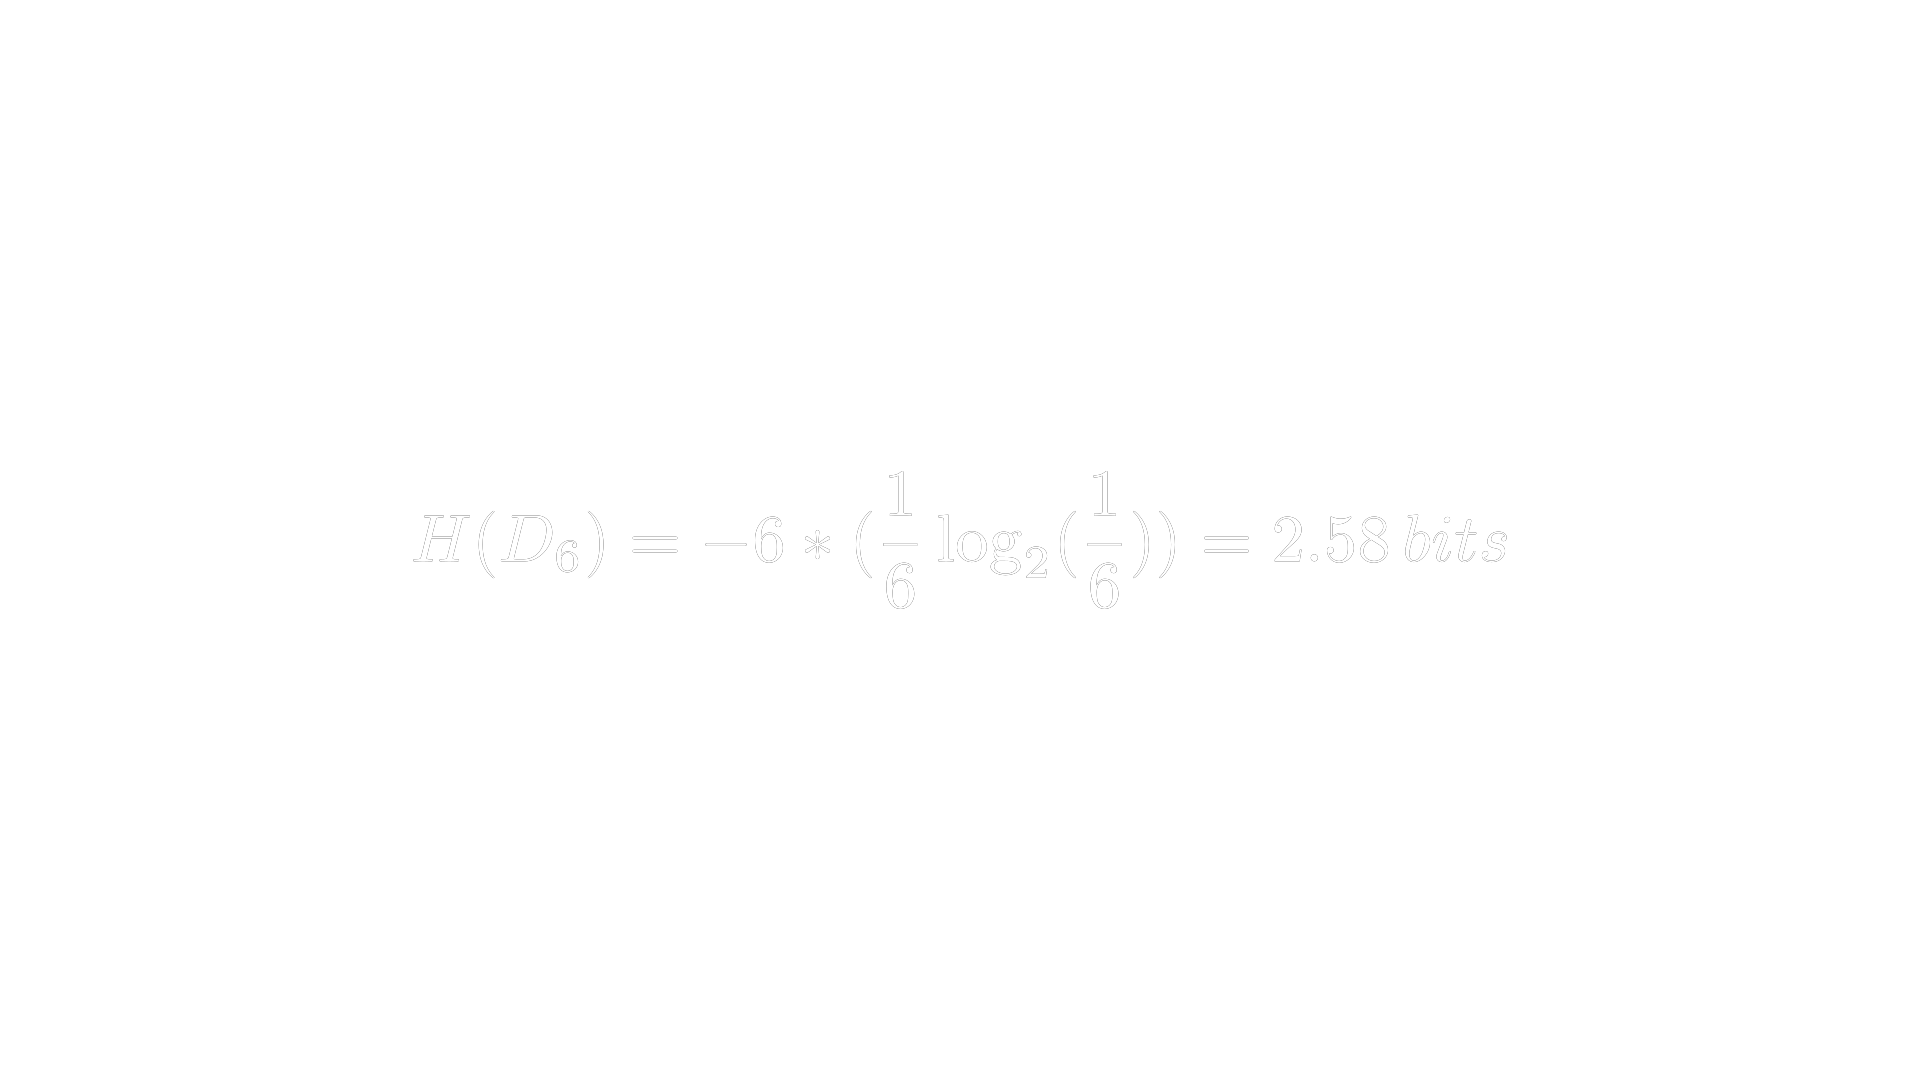

In [55]:
%%manim -qh -s -t --format png -v WARNING EntropyDice

class EntropyDice(Scene):
    def construct(self):
        entropy_formula = MathTex(r"H(D_6) = -6 * (\frac{1}{6} \log_2 (\frac{1}{6})) = 2.58\,bits")
        self.add(entropy_formula)


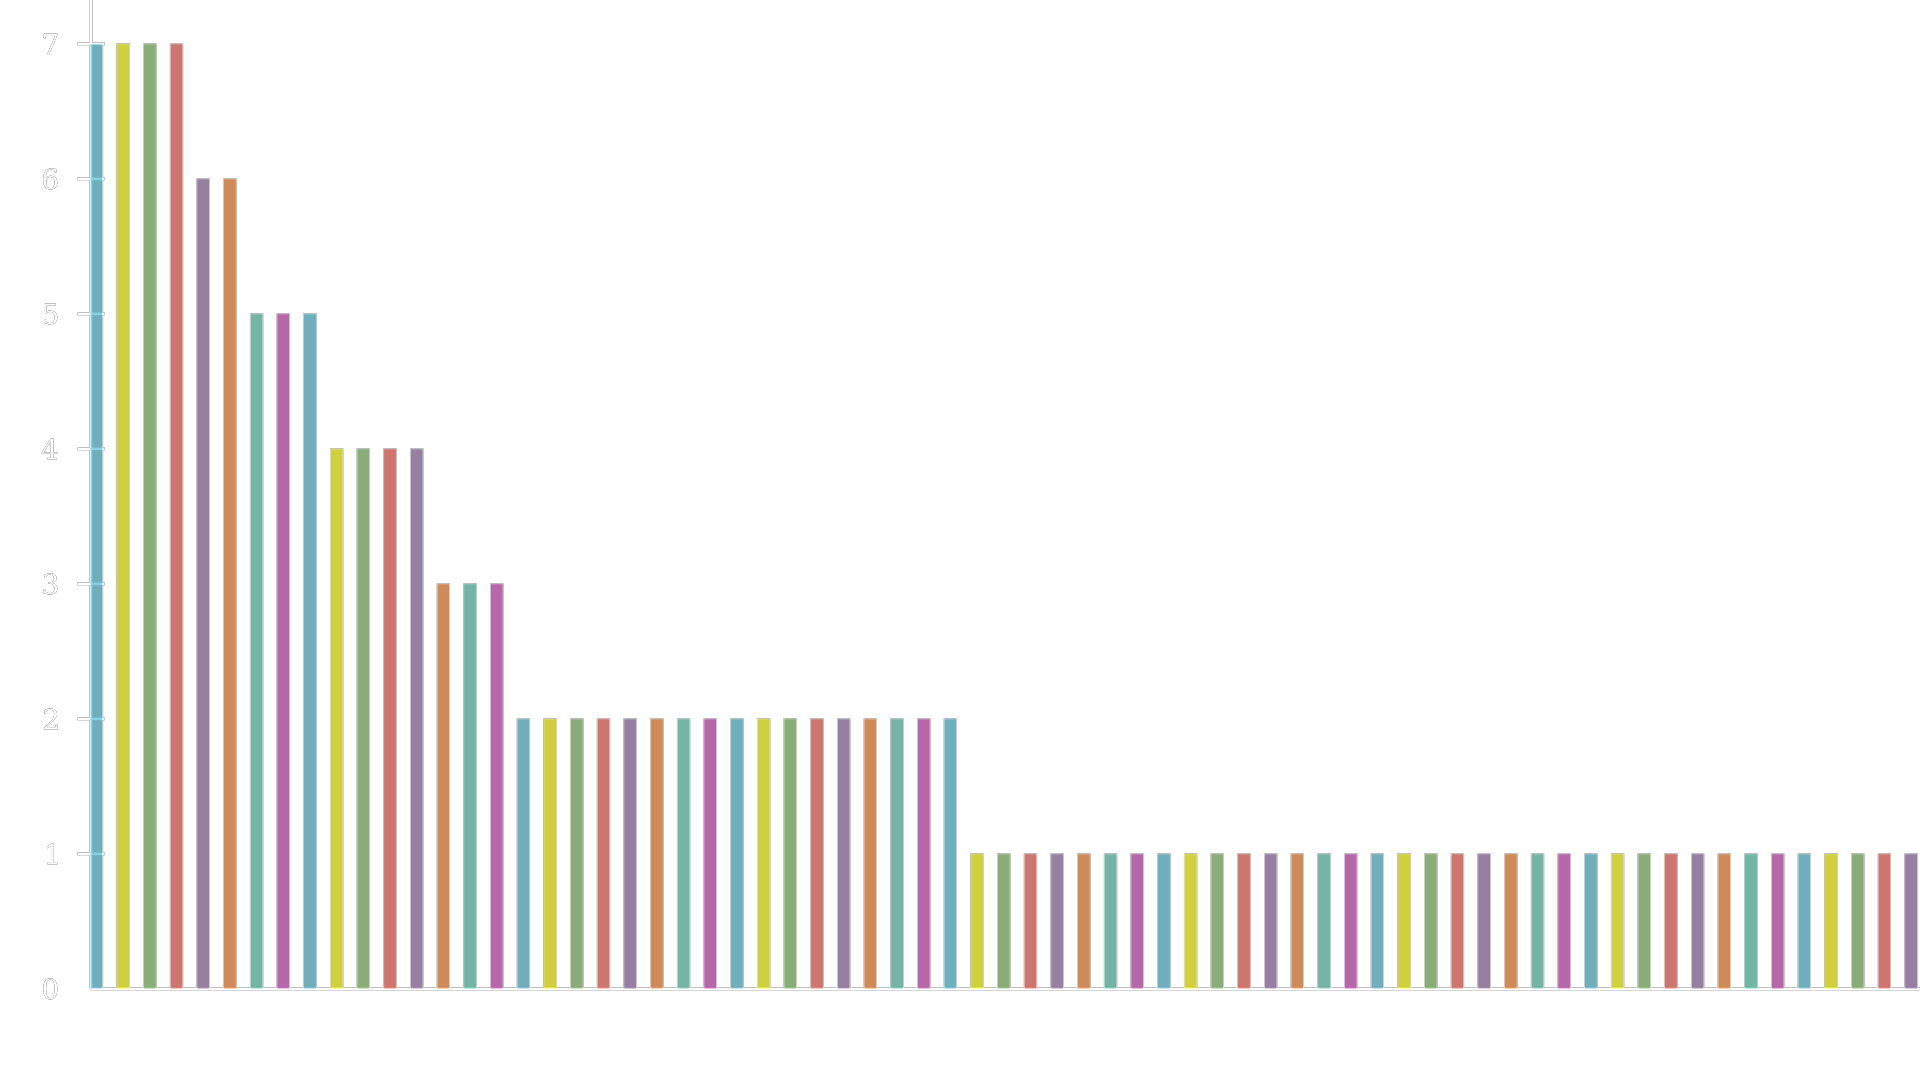

In [53]:
%%manim -qh -t --format png -v WARNING SonaBarChartScene

class SonaBarChartScene(Scene):
    def construct(self):
        outcomes = Solver().get_champion_outcomes('Sona')
        outcomes = outcomes.to_numpy()[:, 1:].astype(float)
        values, counts = np.unique(outcomes, return_counts=True, axis=0)
        sort_idx = np.argsort(-counts)
        data = counts[sort_idx]

        x_max = len(data) + 1
        y_max = max(data) + 1

        bar_width = max(0.075, 8 / x_max)
        x_length = max(8, len(data) / 5)

        axes = Axes(
            x_range=[0, x_max, max(1, x_max // 20)],
            y_range=[0, y_max, max(1, y_max // 10)],
            x_length=x_length,
            y_length=8,
            axis_config={"color": WHITE},
            x_axis_config={"include_ticks": False},
        )
        axes.to_edge(DL)

        step_size = max(1, y_max // 10)
        for y in range(0, y_max, step_size):
            y_label = Text(str(y), font_size=15, color=WHITE).next_to(axes.c2p(0, y), LEFT)
            self.add(y_label)


        bar_colors = [BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK]
        bars = VGroup()
        for i, value in enumerate(data):
            bar = Rectangle(
                width=bar_width,
                height=value,
                fill_color=bar_colors[i % len(bar_colors)],
                fill_opacity=0.75,
                stroke_width=0.5,
                stroke_color=WHITE,
            )
            bar.next_to(axes.c2p(i + 0.2, 0), UP, buff=0)
            bars.add(bar)

        self.add(axes, bars)


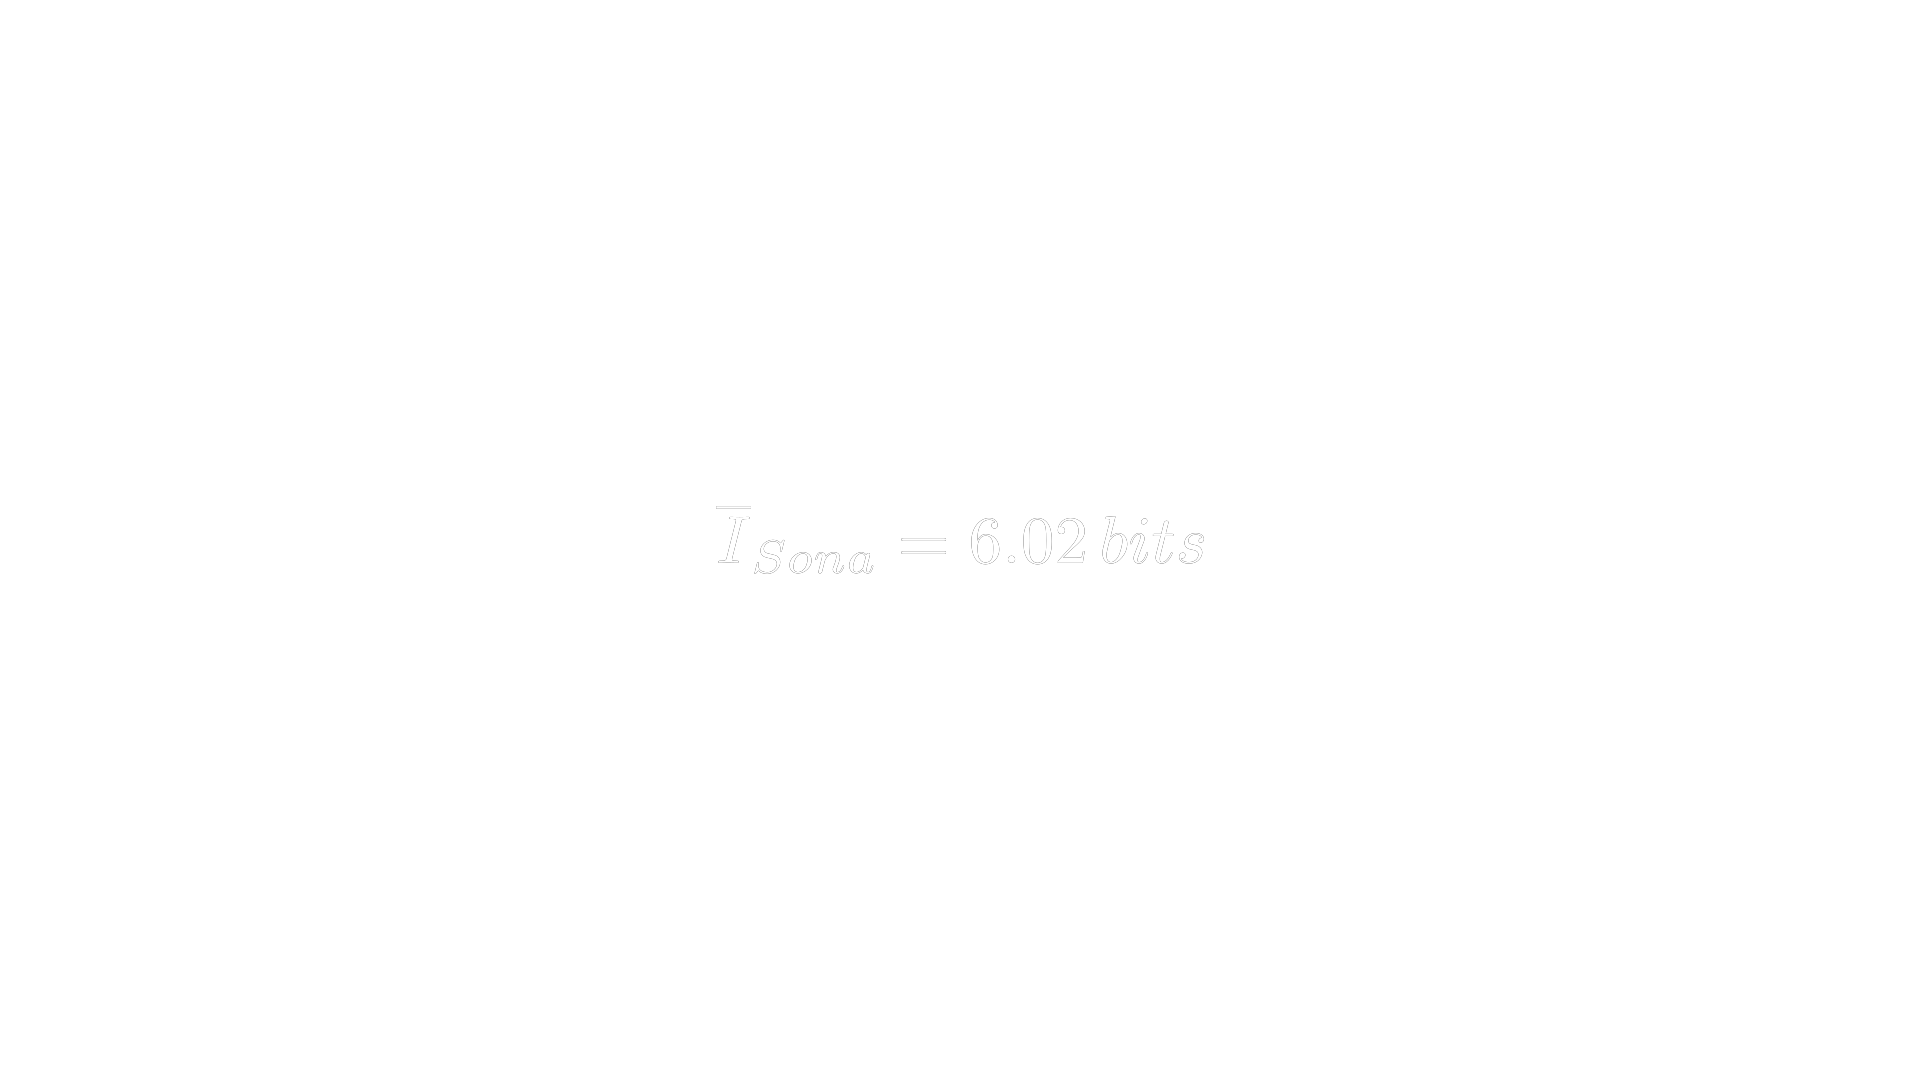

In [66]:
%%manim -qh -t --format png -v WARNING SonaEntropy

class SonaEntropy(Scene):
    def construct(self):
        outcomes = Solver().get_champion_outcomes('Sona')
        outcomes = outcomes.to_numpy()[:, 1:].astype(float)
        _, counts = np.unique(outcomes, return_counts=True, axis=0)
        counts = counts / counts.sum()

        sort_idx = np.argsort(-counts)
        counts = counts[sort_idx]

        entropy = calc_entropy(counts)

        entropy_formula = MathTex(rf"\overline{{I}}_{{Sona}} = {entropy:.2f}\,bits")
        self.add(entropy_formula)


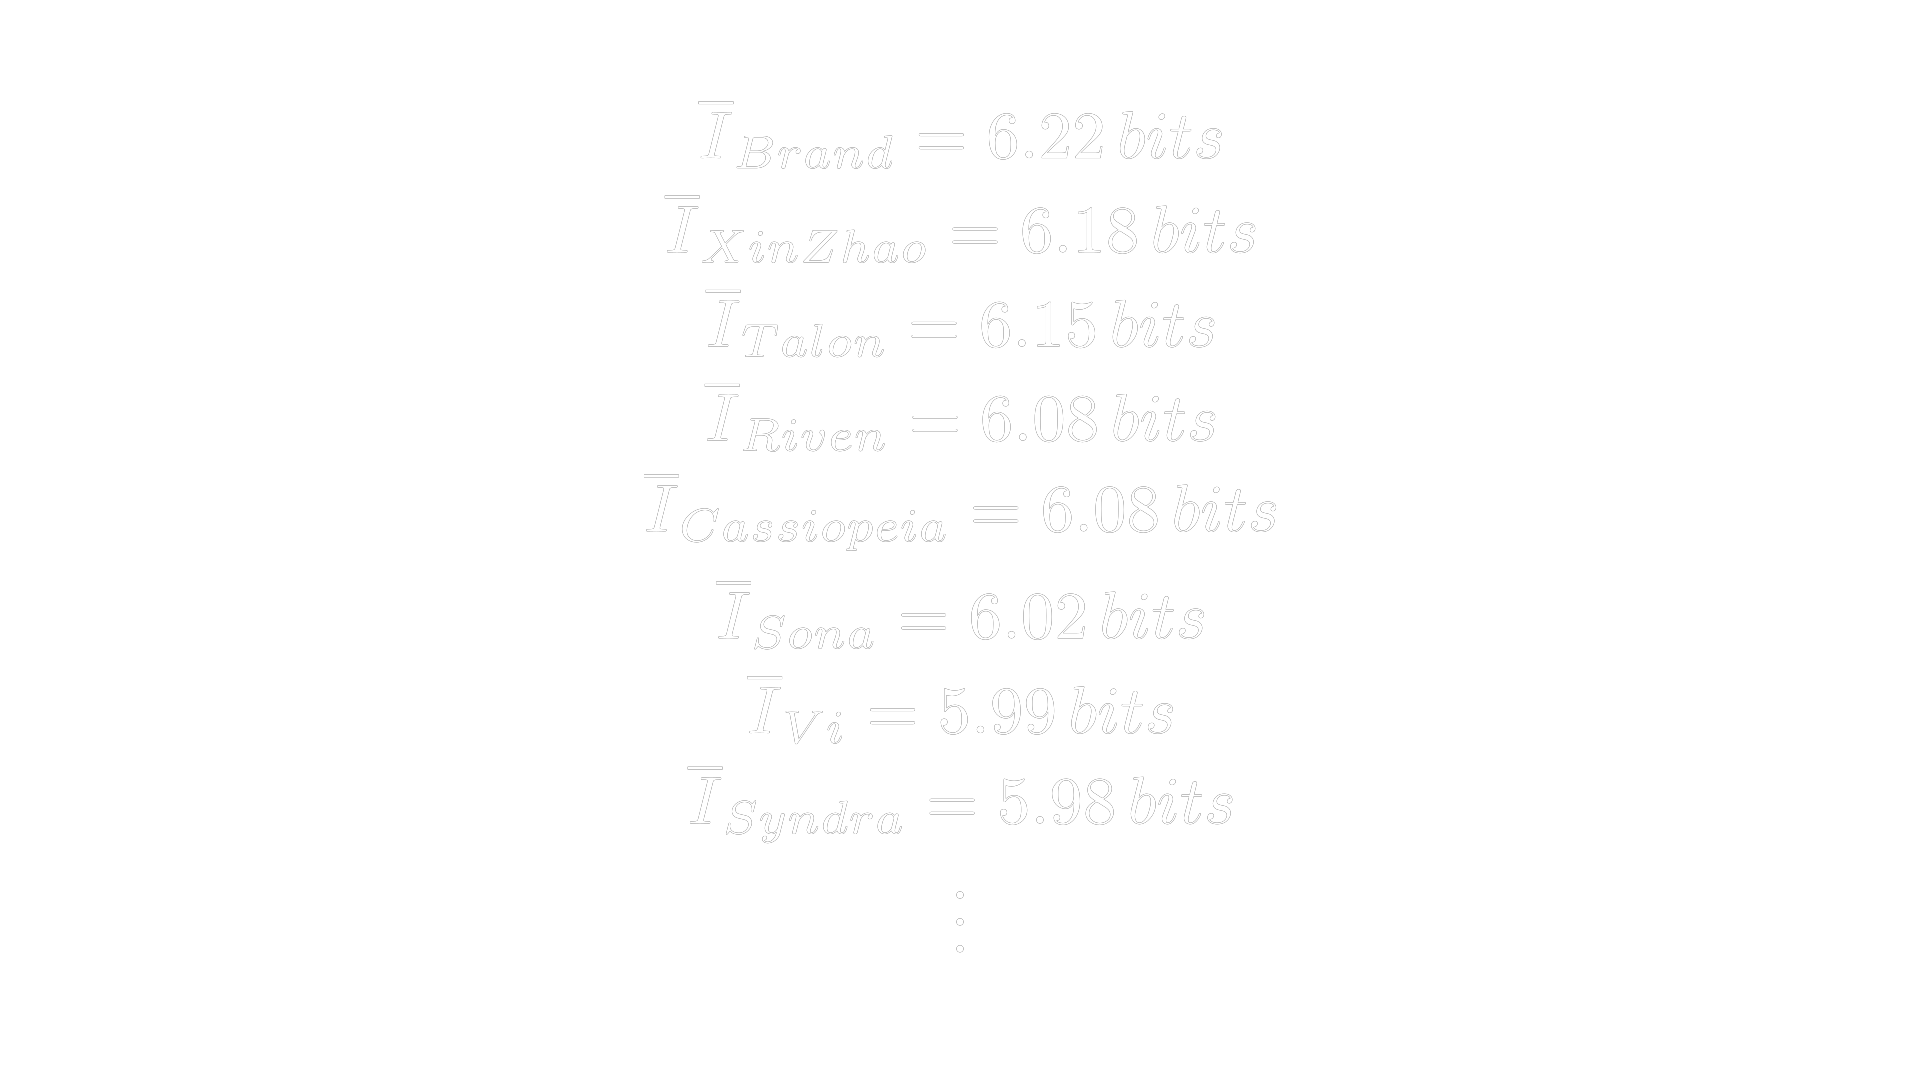

In [182]:
%%manim -qh -t --format png -v WARNING ChampionsEntropy

class ChampionsEntropy(Scene):
    def construct(self):
        solver = Solver()
        entropies = solver.get_best_guesses()
        entropies = [(k, v) for k, v in entropies.items()]

        vertical_spacing = 0.2
        current_y_position = 3

        for champion, entropy in entropies[:8]:
            entropy_formula = MathTex(rf"\overline{{I}}_{{{champion}}} = {entropy:.2f}\,bits")
            entropy_formula.move_to([0, current_y_position, 0])
            self.add(entropy_formula)
            current_y_position -= (entropy_formula.height + vertical_spacing)
        
        vertical_ellipsis = MathTex(r"\vdots")
        vertical_ellipsis.move_to([0, current_y_position - 0.1, 0])
        self.add(vertical_ellipsis)


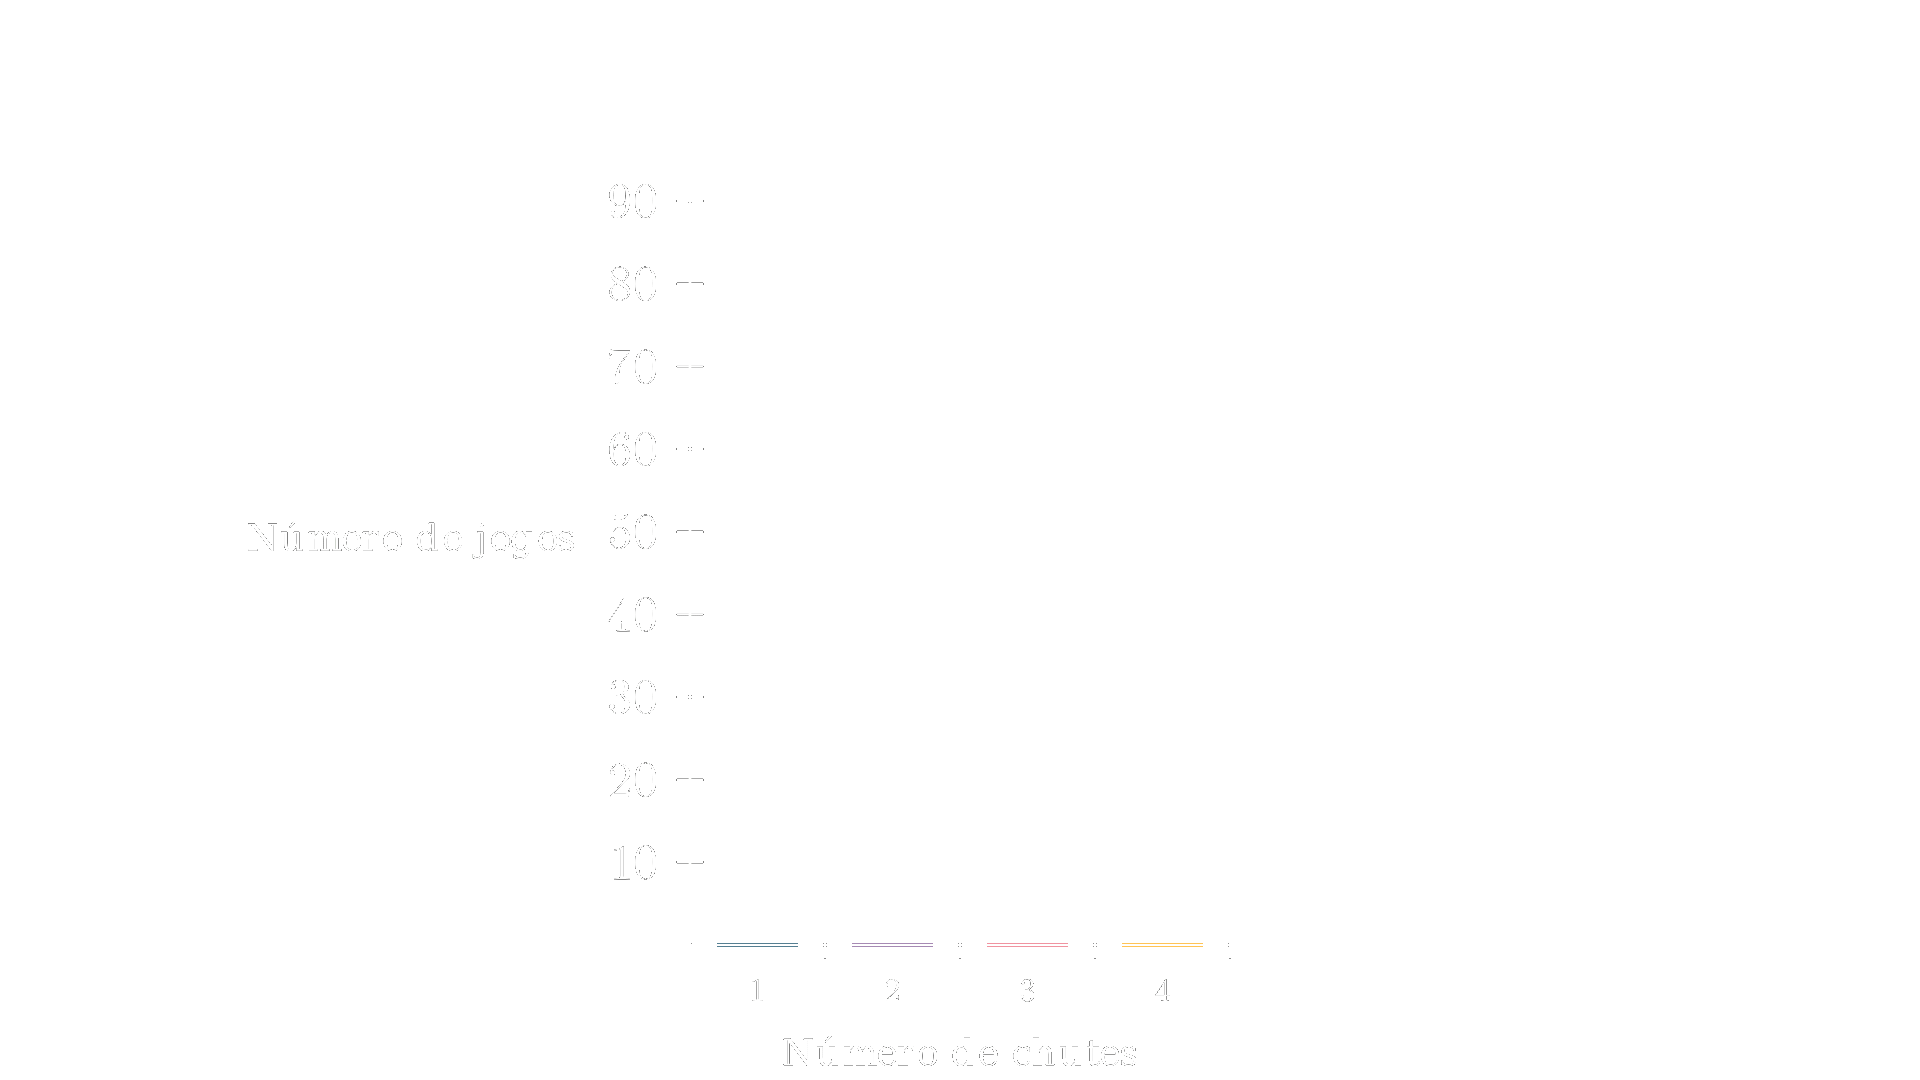

In [221]:
%%manim -qh -t --format gif -v WARNING GamesResultsScene


class GamesResultsScene(Scene):
    def construct(self):
        with open("results.json") as fp:
            results = json.load(fp)
        data = pd.Series(results).value_counts().sort_index().values

        empty_bar_chart = BarChart(
            values=[0] * len(data),
            y_range=[0, max(data) + 10, 10],
            x_length=4,
            y_length=6,
            bar_names=[str(x) for x in range(1, 5)],
        )

        x_axis_name = Text("Número de chutes", font_size=20).next_to(empty_bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de jogos", font_size=20).next_to(empty_bar_chart.y_axis, LEFT)
        self.add(empty_bar_chart, x_axis_name, y_axis_name)

        real_bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED],
            y_range=[0, max(data) + 10, 10],
            x_length=4,
            y_length=6,
            bar_names=[str(x) for x in range(1, 5)],
        )

        for i, bar in enumerate(real_bar_chart.bars):
            self.play(GrowFromEdge(bar, edge=DOWN), run_time=max(0.2 * np.log(data[i]), 0.2))


# Decisão Intuitiva

In [101]:
def prep_column(
    column,
    list_col=False,
    order=None,
    index_map=None,
    sort=True,
    max_len=10,
):
    data = Solver().df.to_pandas()[column]

    if list_col:
        data = list(np.concatenate(data))
    if order is not None:
        data = list(data)
        for value in order:
            data.remove(value)
        data = order + data
        data = [str(x) for x in data]

    series = pd.Series(data).value_counts(sort=sort)
    if len(series) > max_len:
        series = series[:10]
    if index_map is not None:
        series.rename(index=index_map, inplace=True)
    series.index = [str(x) for x in series.index]
    series.index = pd.Series(series.index).str.replace(" ", r"\\")
    series.index = pd.Series(series.index).str.replace("-", r"\\")

    return series.values, series.index.values

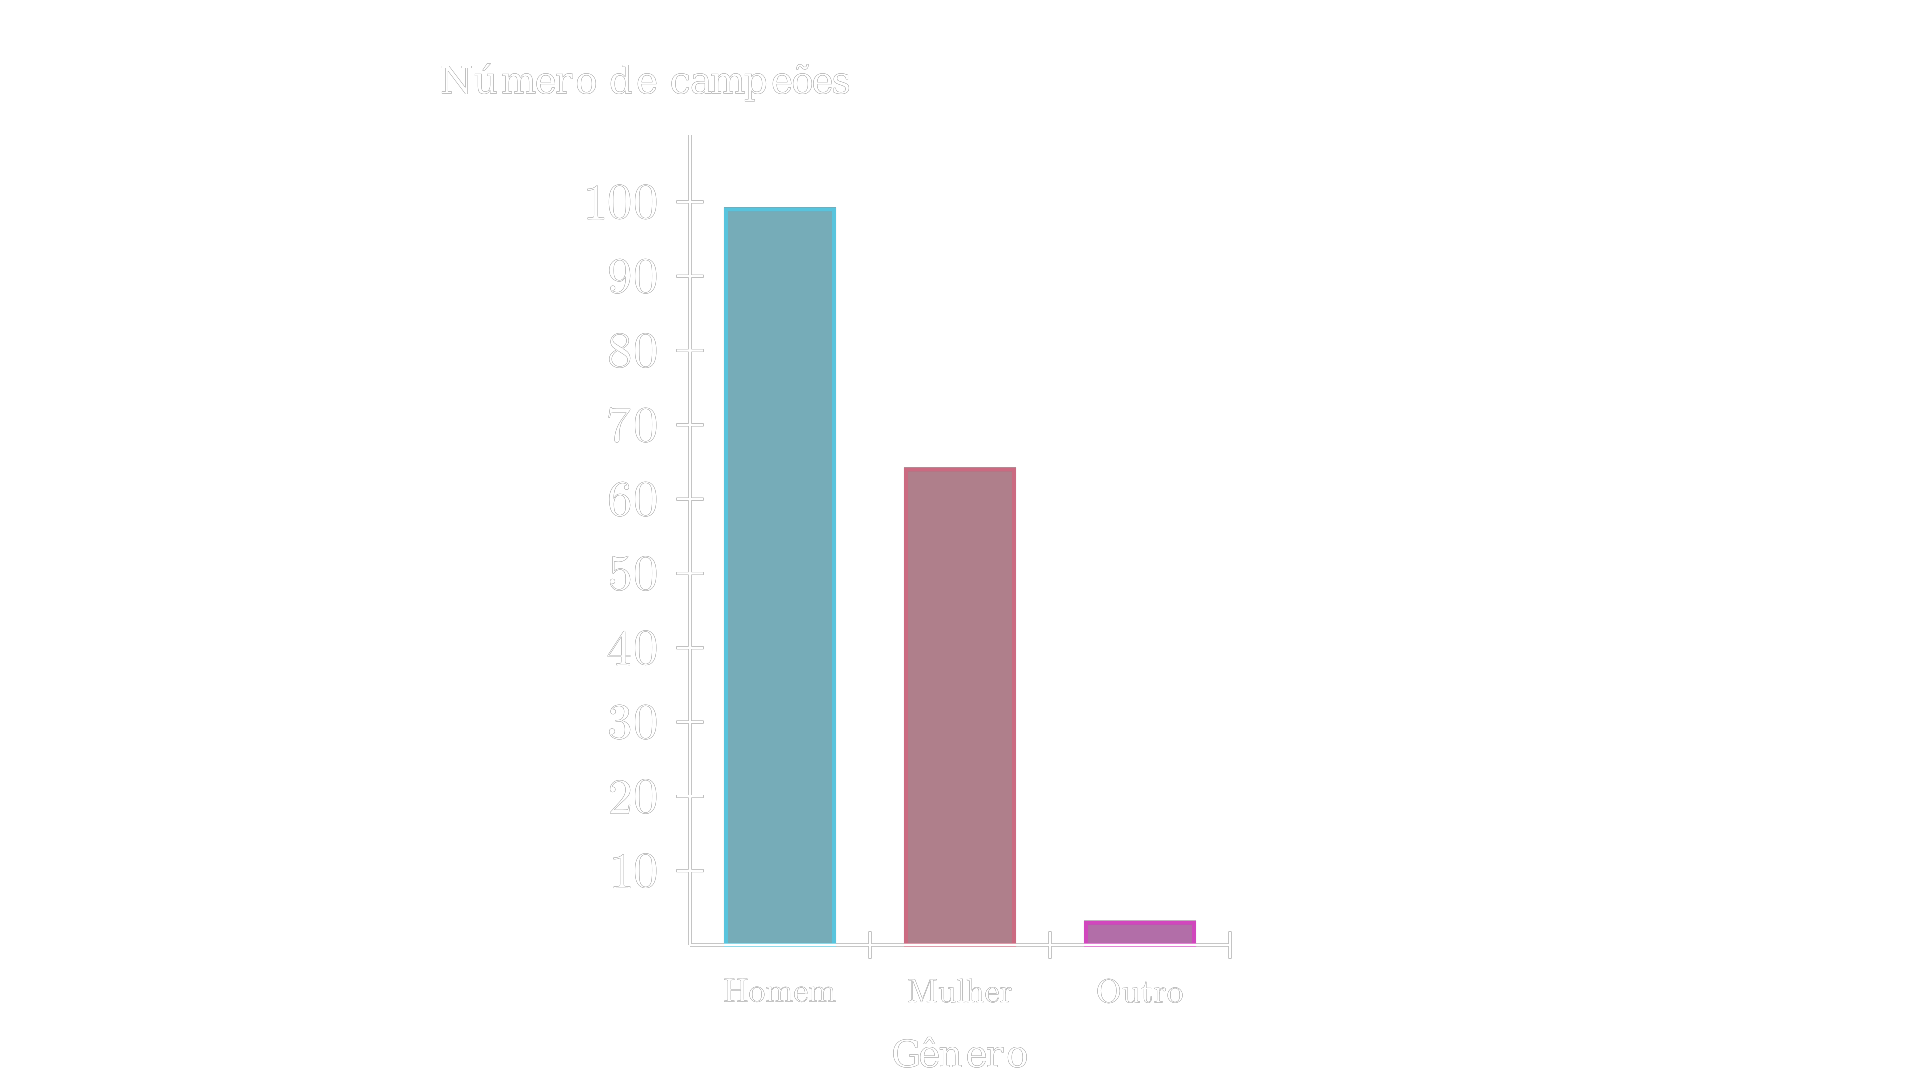

In [116]:
%%manim -qh -t --format png -v WARNING GenderScene


class GenderScene(Scene):
    def construct(self):
        data, index = prep_column(
            "gender",
            index_map={
                'Male': 'Homem',
                'Female': 'Mulher',
                'Other': 'Outro'
            }
        )

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=4,
            y_length=6,
            bar_names=index,
        )

        x_axis_name = Text("Gênero", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)

        self.add(bar_chart, x_axis_name, y_axis_name)


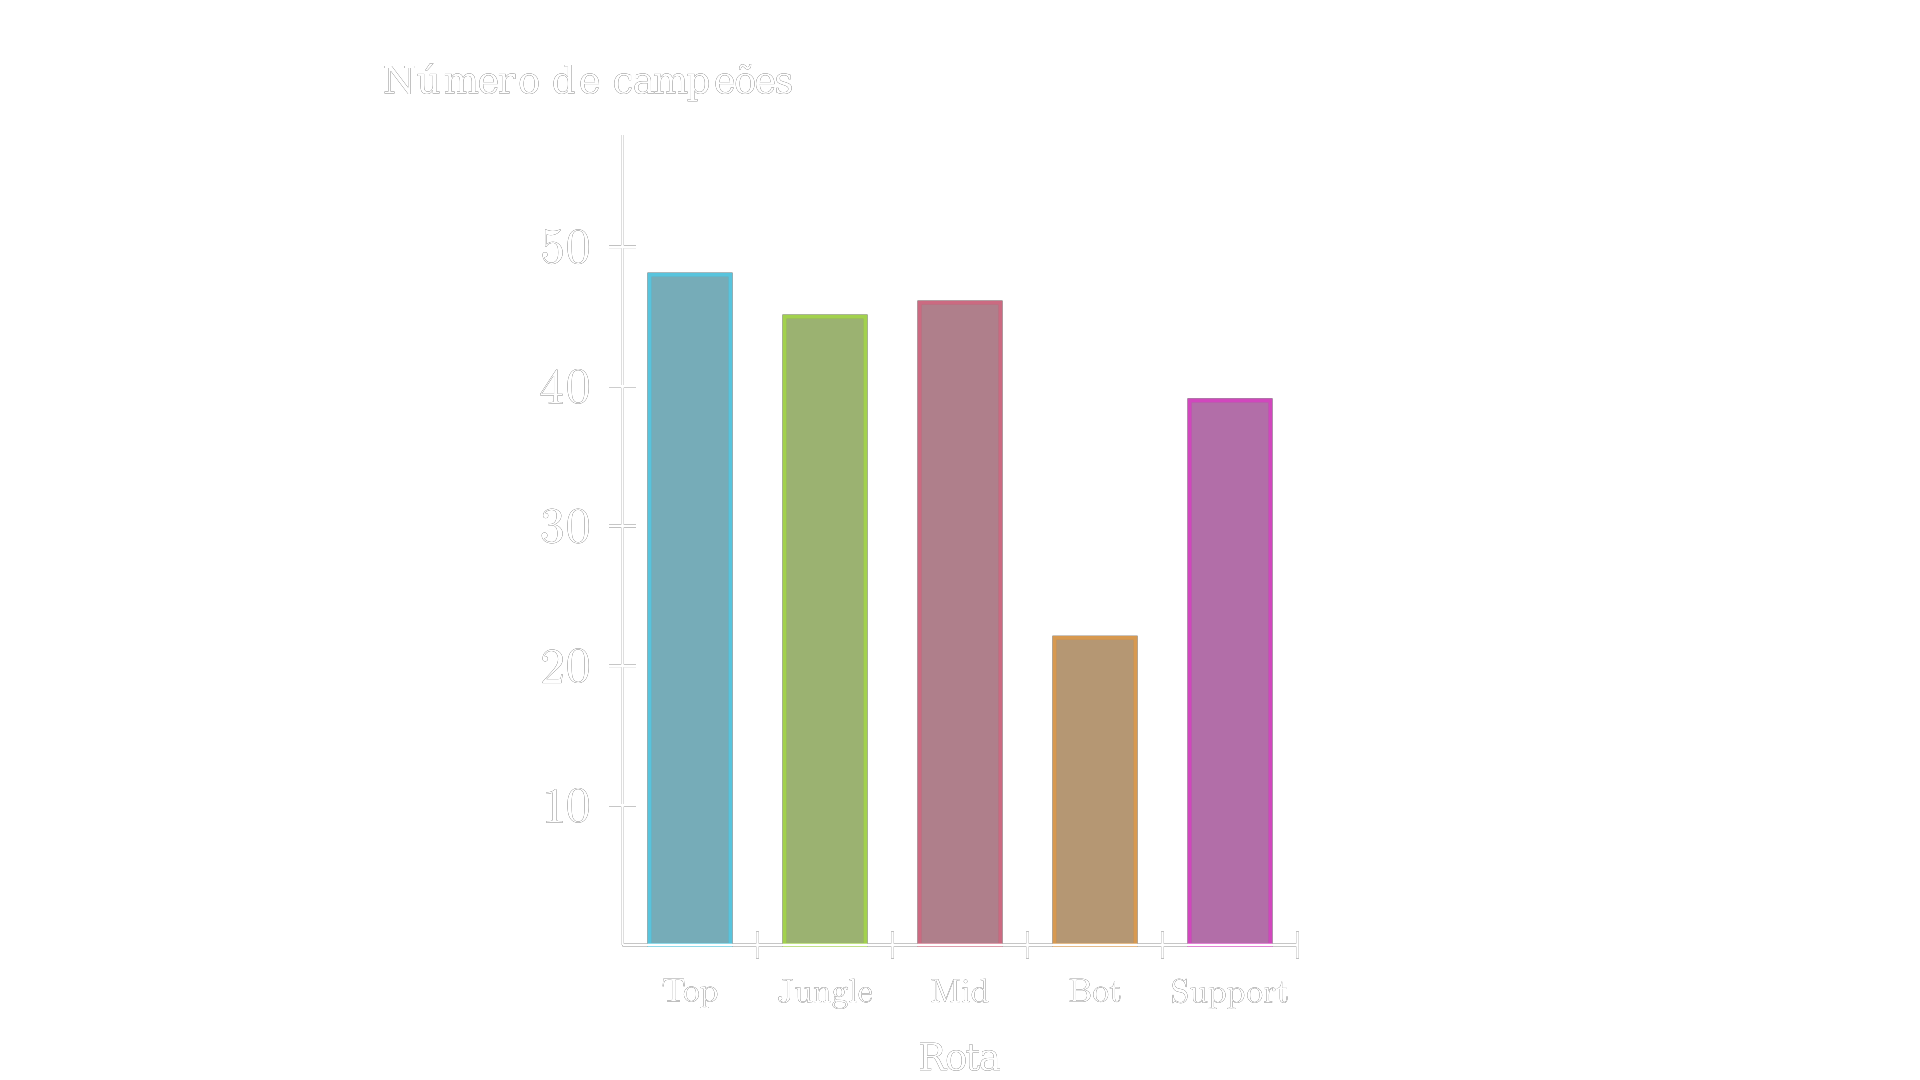

In [117]:
%%manim -qh -t --format png -v WARNING LaneScene


class LaneScene(Scene):
    def construct(self):
        data, index = prep_column(
            "position",
            list_col=True,
            order=['Top', 'Jungle', 'Middle', 'Bottom', 'Support'],
            index_map={
                'Middle': 'Mid',
                'Bottom': 'Bot',
            },
            sort=False,
        )

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=5,
            y_length=6,
            bar_names=index,
        )

        x_axis_name = Text("Rota", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)

        self.add(bar_chart, x_axis_name, y_axis_name)


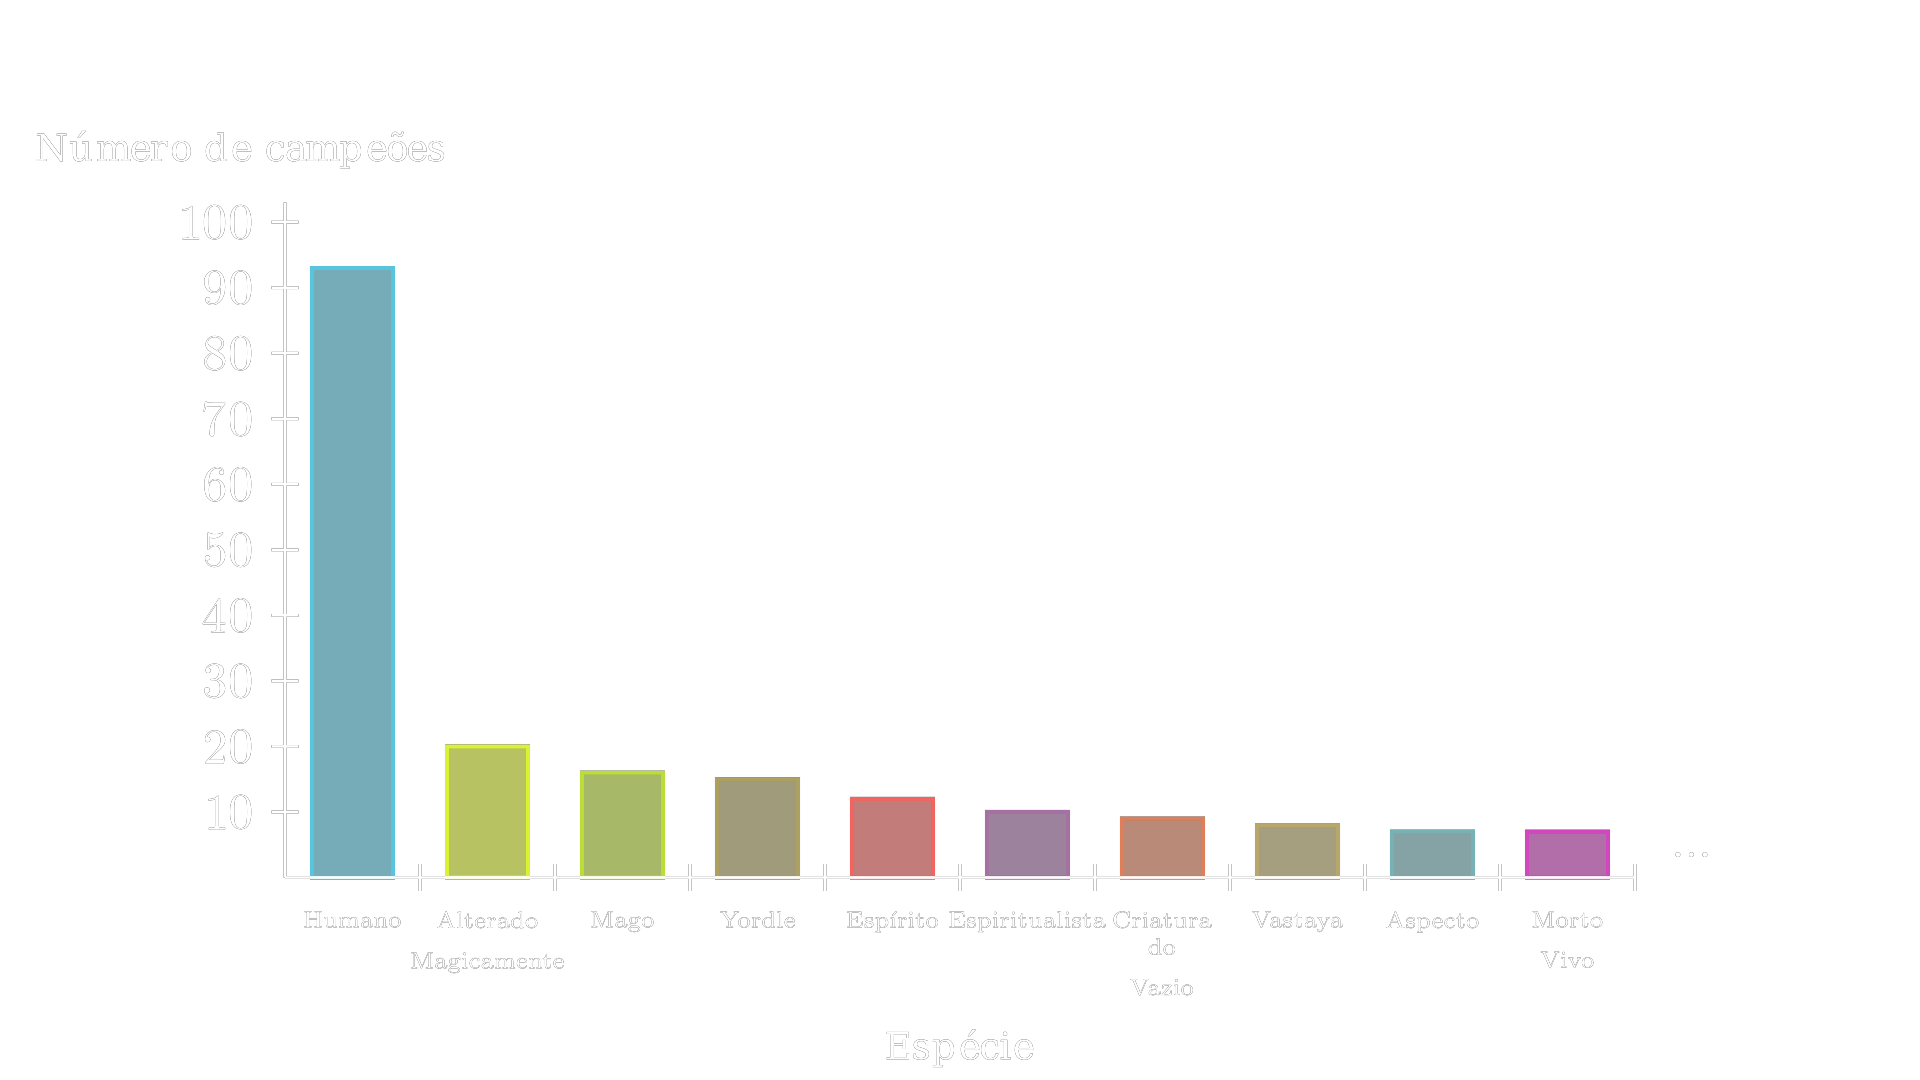

In [118]:
%%manim -qh -t --format png -v WARNING SpeciesScene


class SpeciesScene(Scene):
    def construct(self):
        data, index = prep_column(
            "species",
            list_col=True,
            index_map={
                "Human": "Humano",
                "Magically Altered": "Alterado Magicamente",
                "Magicborn": "Mago",
                "Spirit": "Espírito",
                "Spiritualist": "Espiritualista",
                "Void-Being": "Criatura do Vazio",
                "Vastayan": "Vastaya",
                "Aspect": "Aspecto",
                "Undead": "Morto-Vivo",
            },
            max_len=10,
        )
        index = [rf"{{\scriptsize {idx}}}" for idx in index]

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=10,
            y_length=5,
            bar_names=index,
        )

        x_axis_name = Text("Espécie", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)
        ellipsis = Text("...", font_size=20).next_to(bar_chart.bars[-1], RIGHT, buff=0.5)

        self.add(bar_chart, x_axis_name, y_axis_name, ellipsis)


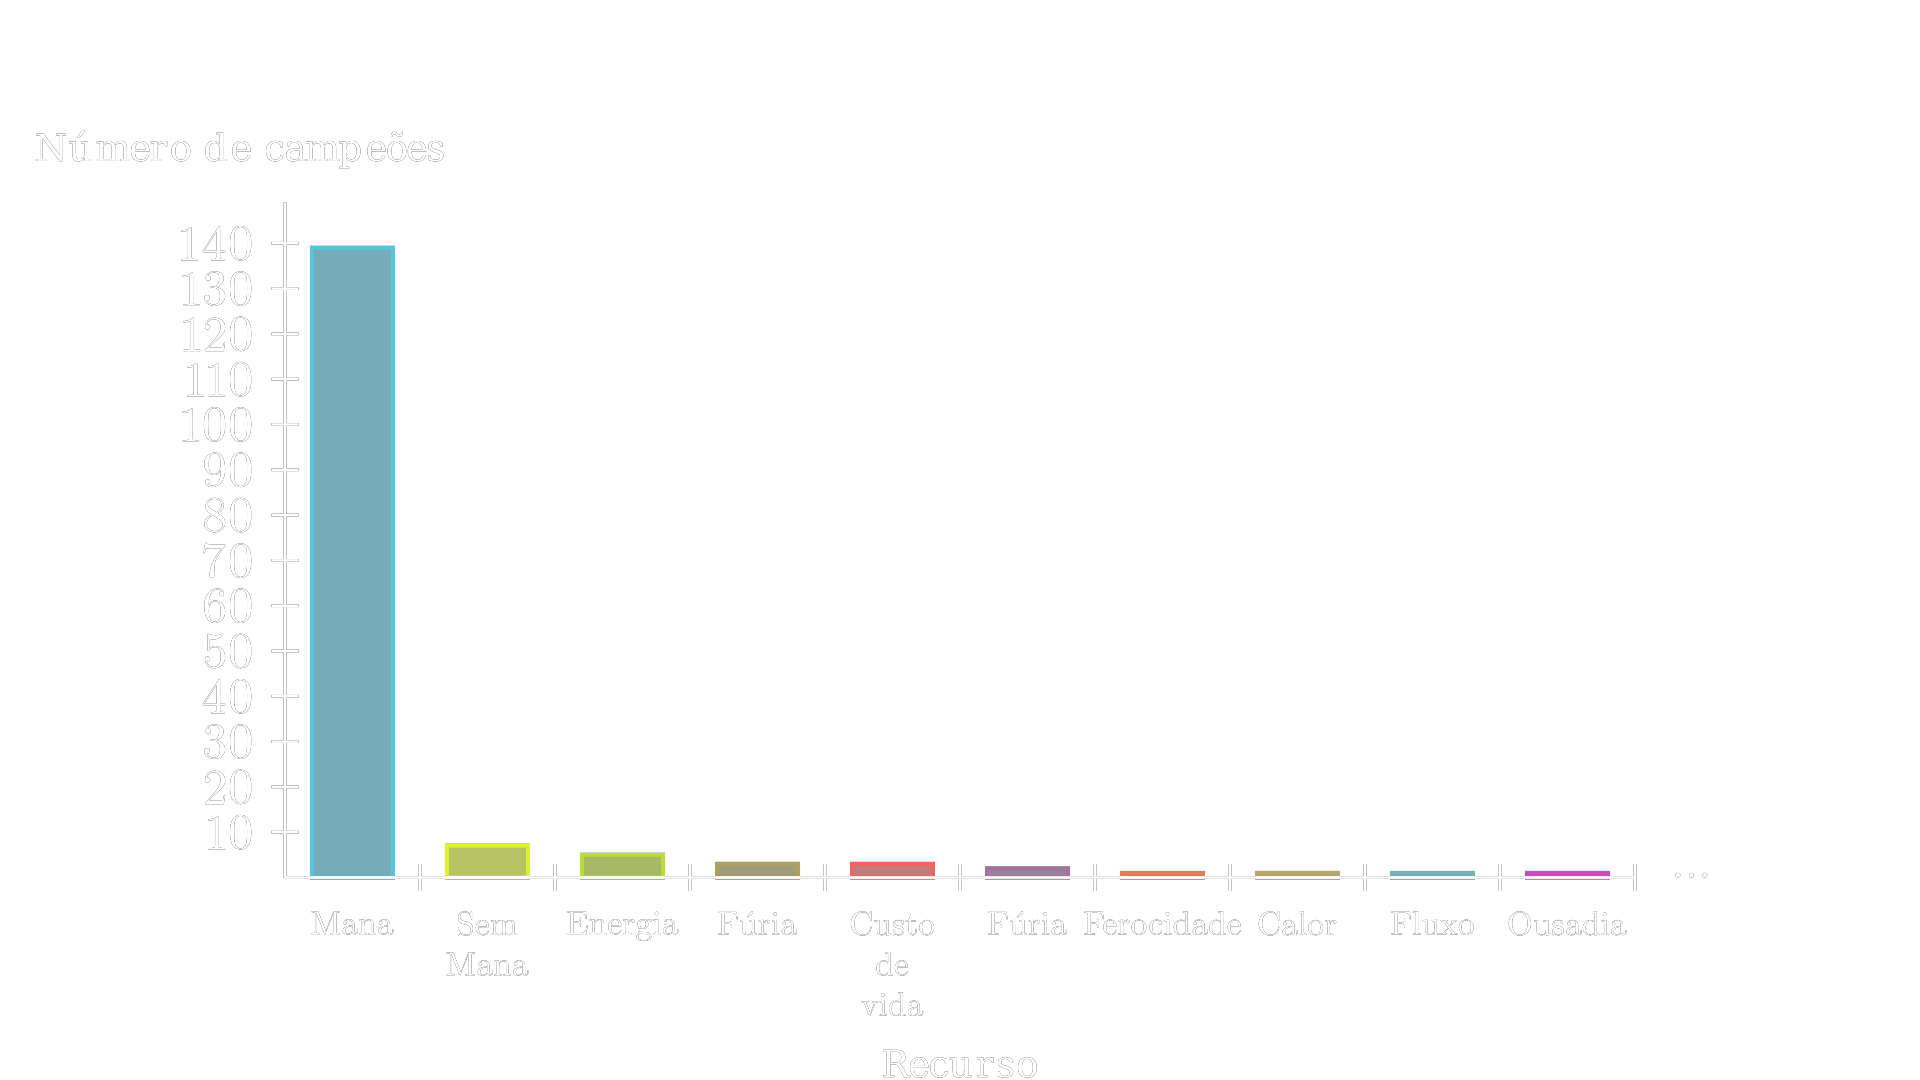

In [119]:
%%manim -qh -t --format png -v WARNING ResourceScene


class ResourceScene(Scene):
    def construct(self):
        data, index = prep_column(
            "resource",
            index_map={
                "Manaless": "Sem Mana",
                "Energy": "Energia",
                "Fury": "Fúria",
                "Health costs": "Custo de vida",
                "Rage": "Fúria",
                "Ferocity": "Ferocidade",
                "Heat": "Calor",
                "Flow": "Fluxo",
                "Grit": "Ousadia",
            }
        )

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=10,
            y_length=5,
            bar_names=index,
        )

        x_axis_name = Text("Recurso", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)
        ellipsis = Text("...", font_size=20).next_to(bar_chart.bars[-1], RIGHT, buff=0.5)

        self.add(bar_chart, x_axis_name, y_axis_name, ellipsis)


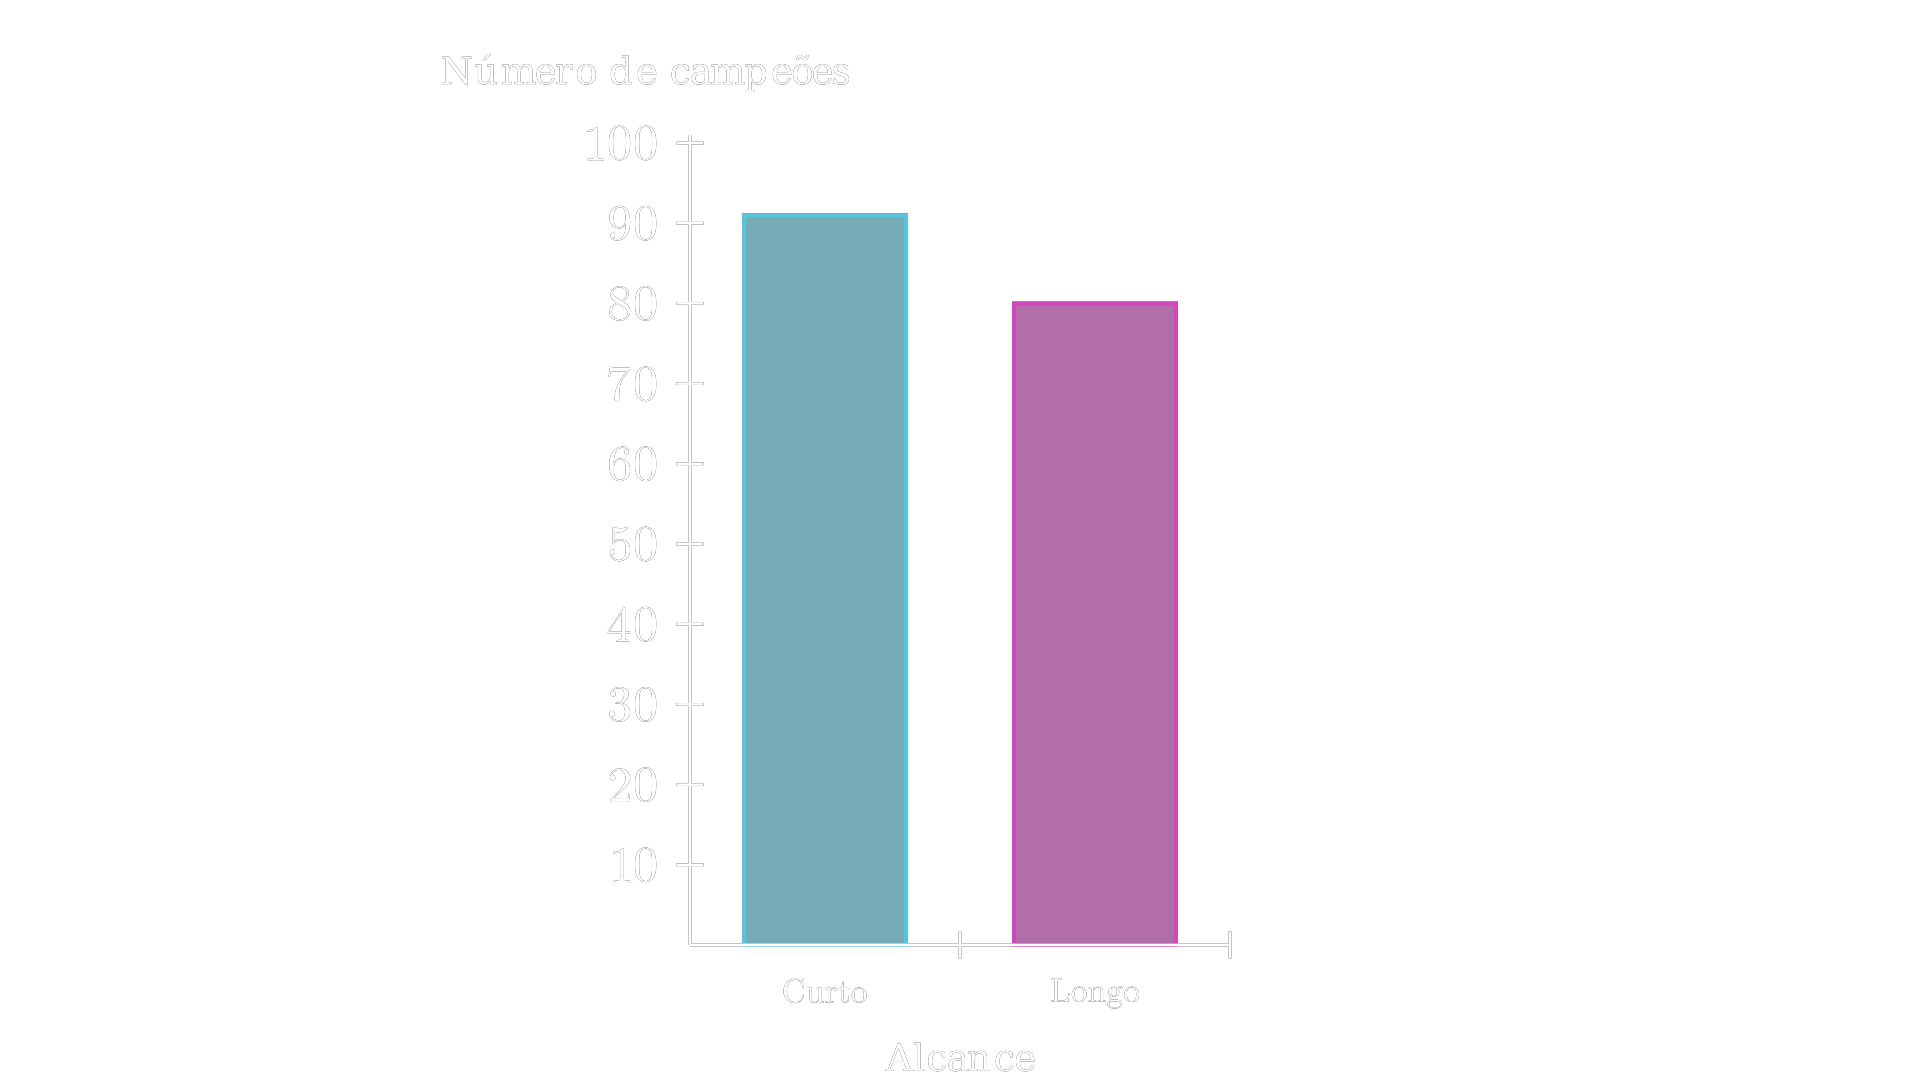

In [120]:
%%manim -qh -t --format png -v WARNING RangeScene


class RangeScene(Scene):
    def construct(self):
        data, index = prep_column(
            "range",
            index_map={
                'Melee': 'Curto',
                'Ranged': 'Longo',
            },
            list_col=True,
        )

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=4,
            y_length=6,
            bar_names=index,
        )

        x_axis_name = Text("Alcance", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)

        self.add(bar_chart, x_axis_name, y_axis_name)


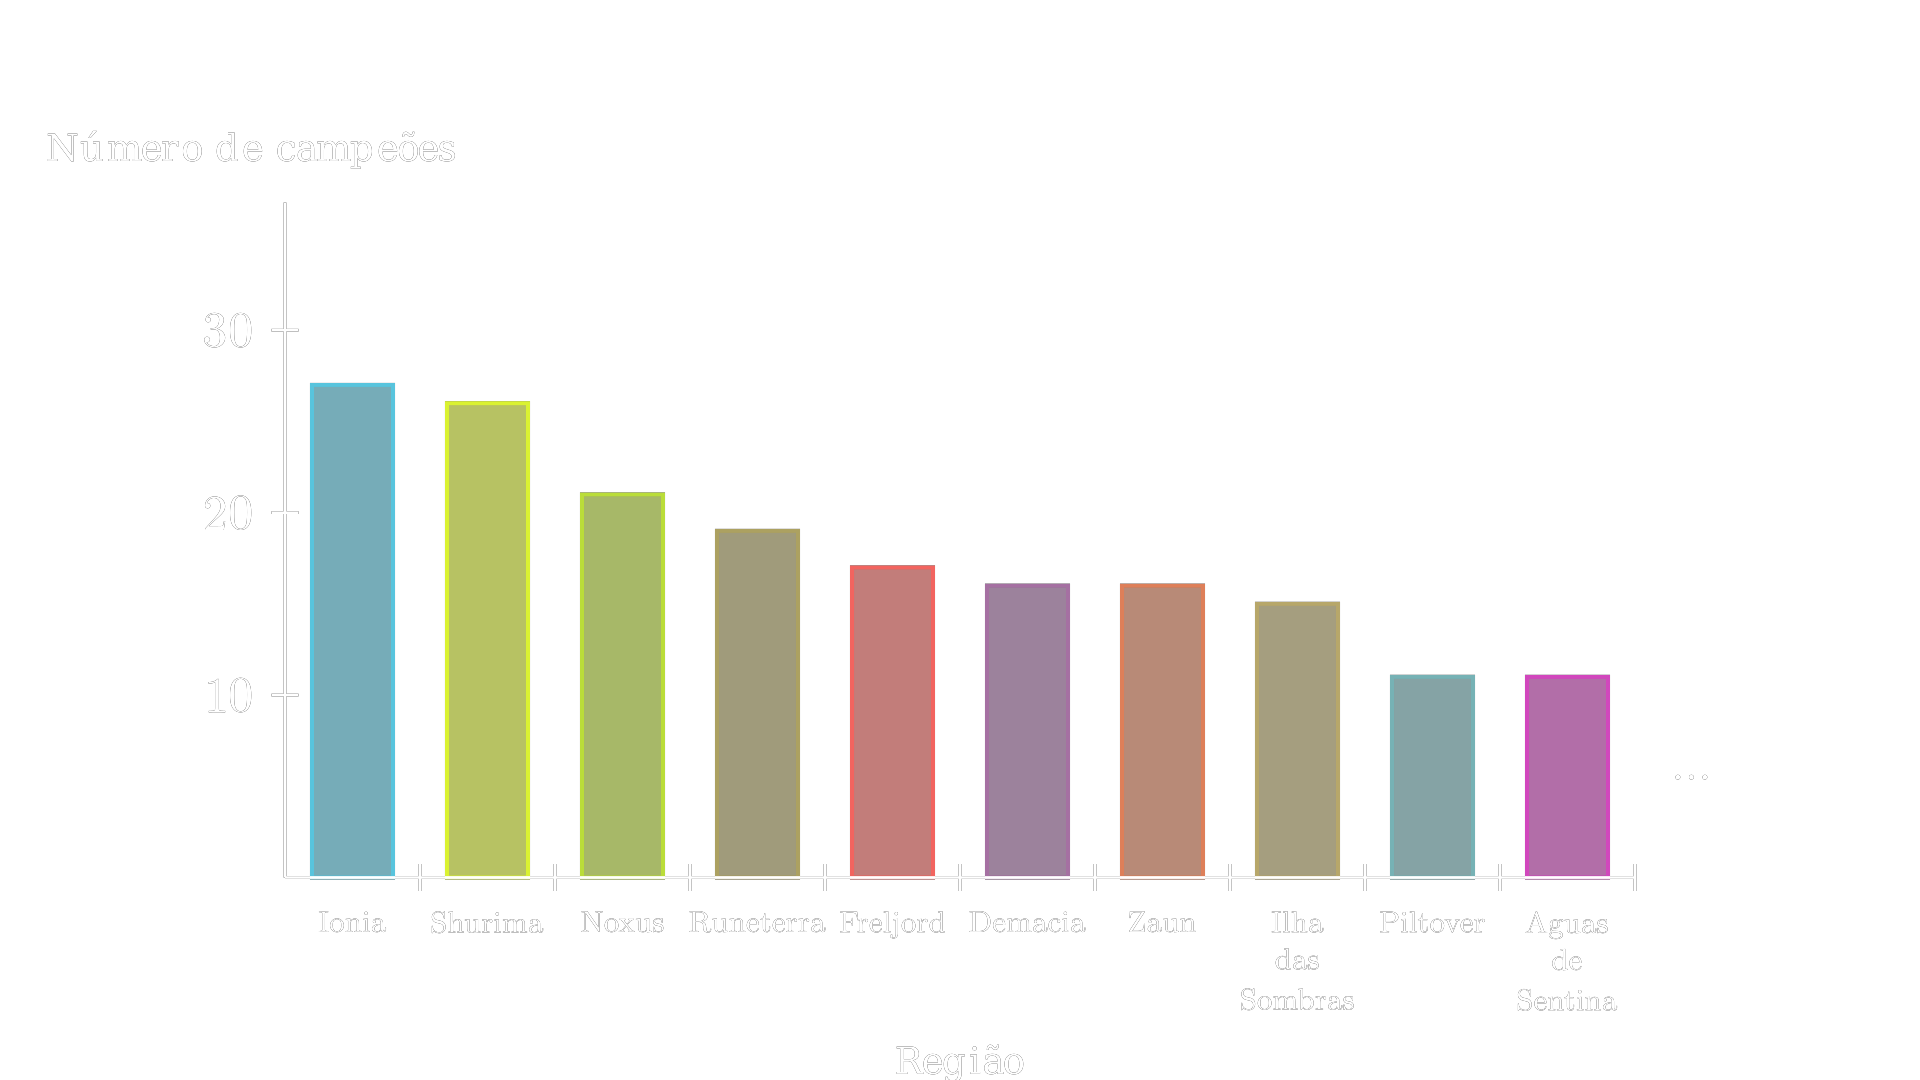

In [121]:
%%manim -qh -t --format png -v WARNING RegionScene


class RegionScene(Scene):
    def construct(self):
        data, index = prep_column(
            "region",
            list_col=True,
            index_map={
                "Shadow Isles": "Ilha das Sombras",
                "Bilgewater": "Aguas de Sentina",
            },
            max_len=10,
        )
        index = [rf"{{\small {idx}}}" for idx in index]

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=10,
            y_length=5,
            bar_names=index,
        )

        x_axis_name = Text("Região", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)
        ellipsis = Text("...", font_size=20).next_to(bar_chart.bars[-1], RIGHT, buff=0.5)

        self.add(bar_chart, x_axis_name, y_axis_name, ellipsis)


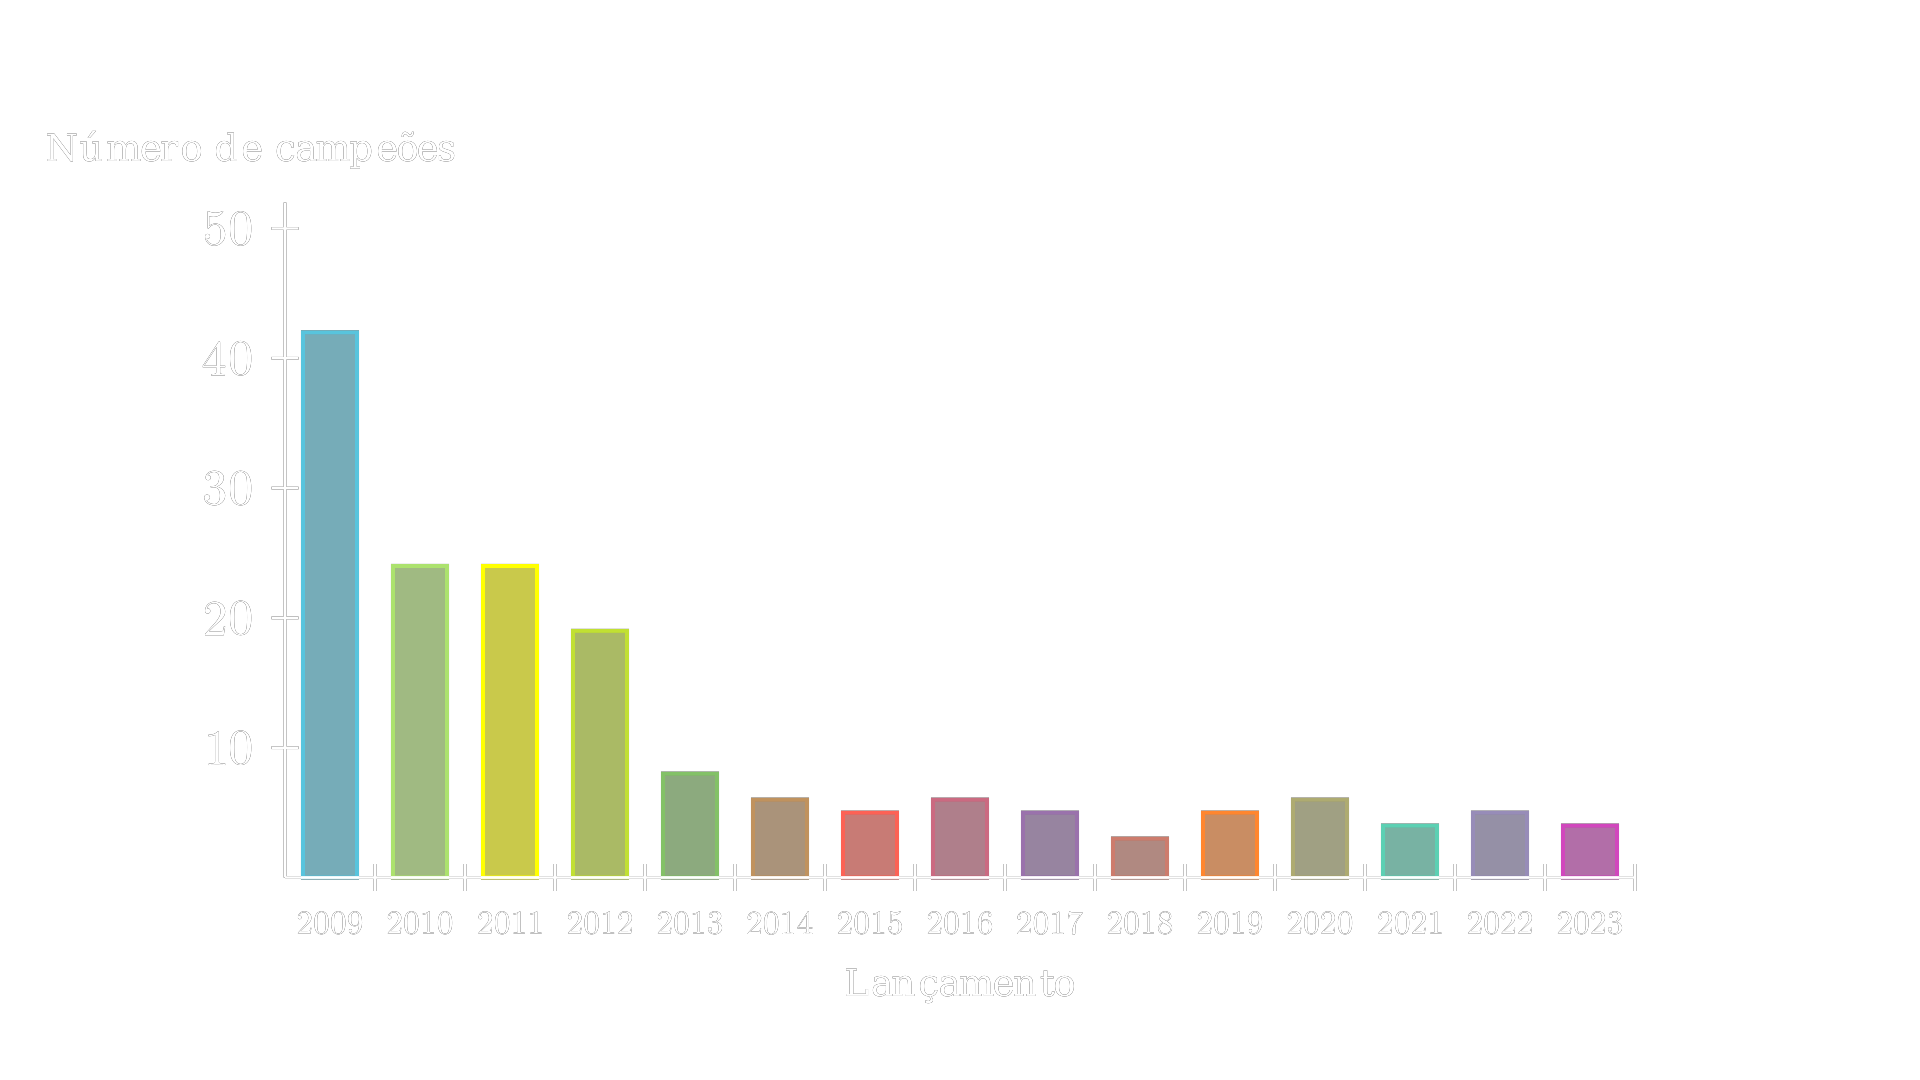

In [123]:
%%manim -qh -t --format png -v WARNING ReleaseScene


class ReleaseScene(Scene):
    def construct(self):
        data, index = prep_column(
            "release",
            order=[x for x in range(2009, 2024)],
            sort=False,
            max_len=30,
        )

        bar_chart = BarChart(
            values=data,
            bar_colors=[BLUE, YELLOW, GREEN, RED, PURPLE, ORANGE, TEAL, PINK],
            y_range=[0, max(data) + 10, 10],
            x_length=10,
            y_length=5,
            bar_names=index,
        )

        x_axis_name = Text("Lançamento", font_size=20).next_to(bar_chart.x_axis, DOWN)
        y_axis_name = Text("Número de campeões", font_size=20).next_to(bar_chart.y_axis, UP)

        self.add(bar_chart, x_axis_name, y_axis_name)
